1. Cкачать набор данных маркетинговых кампаний отсюда https://www.kaggle.com/davinwijaya/customer-retention .
там поле conversion - это целевая переменная, а offer - коммуникация. Переименовать поля (conversion -> target, offer -> treatment) и привести поле treatment к бинарному виду (1 или 0, т.е было какое-то предложение или нет) - значение No Offer означает отсутствие коммуникации, а все остальные - наличие.
2. сделать разбиение набора данных не тренировочную и тестовую выборки.
3. сделать feature engineering на ваше усмотрение (допускается свобода выбора методов).
4. провести uplift-моделирование 3 способами: одна модель с признаком коммуникации (S learner), модель с трансформацией таргета (трансформация классов п. 2. 1) и вариант с двумя независимыми моделями.
5. в конце вывести единую таблицу сравнения метрик uplift@10%, uplift@20% этих 3 моделей.

Произведем загрузку необходимых библиотек.

In [51]:
pip install scikit-uplift==0.2.0

In [52]:
import numpy as np
import pandas as pd

from sklearn.model_selection import train_test_split
from sklearn import preprocessing
from sklearn.preprocessing import MinMaxScaler

from sklift.metrics import uplift_at_k
from sklift.viz import plot_uplift_preds
from sklift.models import SoloModel
from sklift.models import ClassTransformation
from sklift.models import TwoModels

from catboost import CatBoostClassifier

Считаем информацию из файла.

In [53]:
df = pd.read_csv('data.csv')

In [54]:
df.shape

(64000, 9)

In [55]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 64000 entries, 0 to 63999
Data columns (total 9 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   recency        64000 non-null  int64  
 1   history        64000 non-null  float64
 2   used_discount  64000 non-null  int64  
 3   used_bogo      64000 non-null  int64  
 4   zip_code       64000 non-null  object 
 5   is_referral    64000 non-null  int64  
 6   channel        64000 non-null  object 
 7   offer          64000 non-null  object 
 8   conversion     64000 non-null  int64  
dtypes: float64(1), int64(5), object(3)
memory usage: 4.4+ MB


Проведем переименование столбцов 'conversion' и offer' в 'target' и 'treatment' соответственнло.

In [56]:
df.rename(columns={'conversion':'target', 'offer':'treatment'}, inplace=True)

In [57]:
df.head()

,recency,history,used_discount,used_bogo,zip_code,is_referral,channel,treatment,target
0,10,142.44,1,0,Surburban,0,Phone,Buy One Get One,0
1,6,329.08,1,1,Rural,1,Web,No Offer,0
2,7,180.65,0,1,Surburban,1,Web,Buy One Get One,0
3,9,675.83,1,0,Rural,1,Web,Discount,0
4,2,45.34,1,0,Urban,0,Web,Buy One Get One,0


In [58]:
df['treatment'].value_counts()

Buy One Get One    21387
Discount           21307
No Offer           21306
Name: treatment, dtype: int64

Заменим значения в столбце 'treatment' с категориальных на числовые- на 0 и 1.

In [59]:
df = df.replace({'treatment':{'No Offer':0, 'Buy One Get One':1, 'Discount':1}})

In [60]:
df['treatment'].value_counts()

1    42694
0    21306
Name: treatment, dtype: int64

Разделим датасет на тренировочную и тестовую выборки.

In [61]:
X_train, X_test, y_train, y_test = train_test_split(df.drop('target', axis=1),
                                                    df['target'],
                                                    test_size=0.3,
                                                    random_state=42)

Применим One-Hot Encoding для кодирования оставшихся категориальных признаков.

In [62]:
X_train = pd.get_dummies(X_train)
X_test = pd.get_dummies(X_test)

In [63]:
treat_train = X_train['treatment']
treat_test = X_test['treatment']
models_results = {
    'method': [],
    'uplift@10%': [],
    'uplift@30%': []
}

Проведем Uplift-моделрование при помощи модель с признаком коммуникации (S learner).

In [64]:
sm = SoloModel(CatBoostClassifier(iterations=20, thread_count=2, random_state=42, silent=True))
sm = sm.fit(X_train, y_train, treat_train)

uplift_sm = sm.predict(X_test)

sm_score_10 = uplift_at_k(y_true=y_test, uplift=uplift_sm, treatment=treat_test, strategy='by_group', k=0.1)
sm_score_30 = uplift_at_k(y_true=y_test, uplift=uplift_sm, treatment=treat_test, strategy='by_group', k=0.3)

models_results['method'].append('SoloModel')
models_results['uplift@10%'].append(sm_score_10)
models_results['uplift@30%'].append(sm_score_30)

Вычислим условные вероятности выполнения целевого действия при взаимодействии для каждого объекта.

In [65]:
sm_trmnt_preds = sm.trmnt_preds_

Вычислим условные вероятности выполнения целевого действия без взаимодействия для каждого объекта.

In [66]:
sm_ctrl_preds = sm.ctrl_preds_

Визуализируем полученные результаты.

array([<AxesSubplot:title={'center':'Treatment predictions'}, ylabel='Probability hist'>,
       <AxesSubplot:title={'center':'Control predictions'}>,
       <AxesSubplot:title={'center':'Uplift predictions'}>], dtype=object)

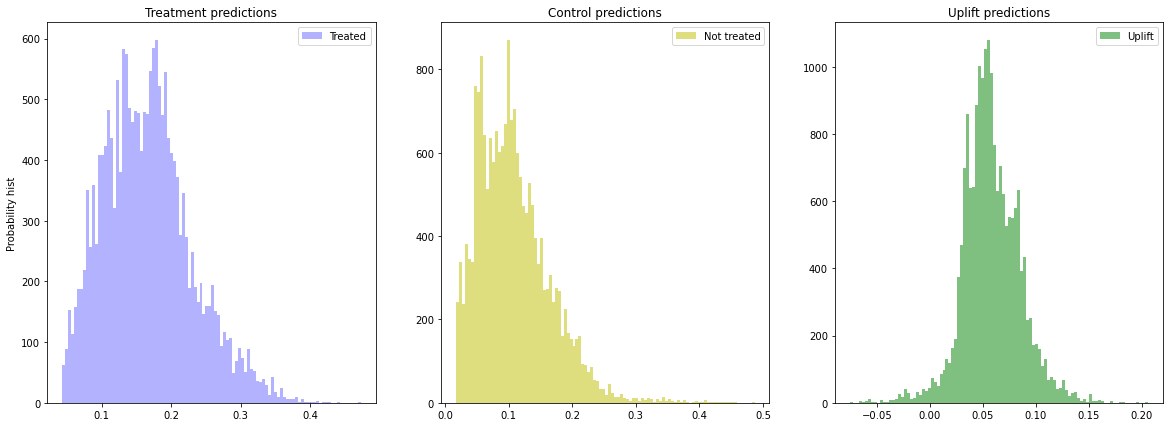

In [67]:
plot_uplift_preds(trmnt_preds=sm_trmnt_preds, ctrl_preds=sm_ctrl_preds)

Проведем Uplift-моделрование при помощи модели с трансформацией таргета.

In [68]:
ct = ClassTransformation(CatBoostClassifier(iterations=20, thread_count=2, random_state=42, silent=True))
ct = ct.fit(X_train, y_train, treat_train)

uplift_ct = ct.predict(X_test)

ct_score_10 = uplift_at_k(y_true=y_test, uplift=uplift_ct, treatment=treat_test, strategy='by_group', k=0.1)
ct_score_30 = uplift_at_k(y_true=y_test, uplift=uplift_ct, treatment=treat_test, strategy='by_group', k=0.3)

models_results['method'].append('ClassTransformation')
models_results['uplift@10%'].append(ct_score_10)
models_results['uplift@30%'].append(ct_score_30)

<ipython-input-68-67cd509eb7b3>:2: UserWarning: It is recommended to use this approach on treatment balanced data. Current sample size is unbalanced.
  ct = ct.fit(X_train, y_train, treat_train)


Проведем Uplift-моделрование при помощи варианта с двумя независимыми моделями.

In [69]:
tm = TwoModels(
    estimator_trmnt=CatBoostClassifier(iterations=20, thread_count=2, random_state=42, silent=True), 
    estimator_ctrl=CatBoostClassifier(iterations=20, thread_count=2, random_state=42, silent=True), 
    method='vanilla')

tm = tm.fit(
    X_train, y_train, treat_train)

uplift_tm = tm.predict(X_test)

tm_score_10 = uplift_at_k(y_true=y_test, uplift=uplift_tm, treatment=treat_test, strategy='by_group', k=0.1)
tm_score_30 = uplift_at_k(y_true=y_test, uplift=uplift_tm, treatment=treat_test, strategy='by_group', k=0.3)

models_results['method'].append('TwoModels')
models_results['uplift@10%'].append(tm_score_10)
models_results['uplift@30%'].append(tm_score_30)

Визуазизируем полученные результаты.

array([<AxesSubplot:title={'center':'Treatment predictions'}, ylabel='Probability hist'>,
       <AxesSubplot:title={'center':'Control predictions'}>,
       <AxesSubplot:title={'center':'Uplift predictions'}>], dtype=object)

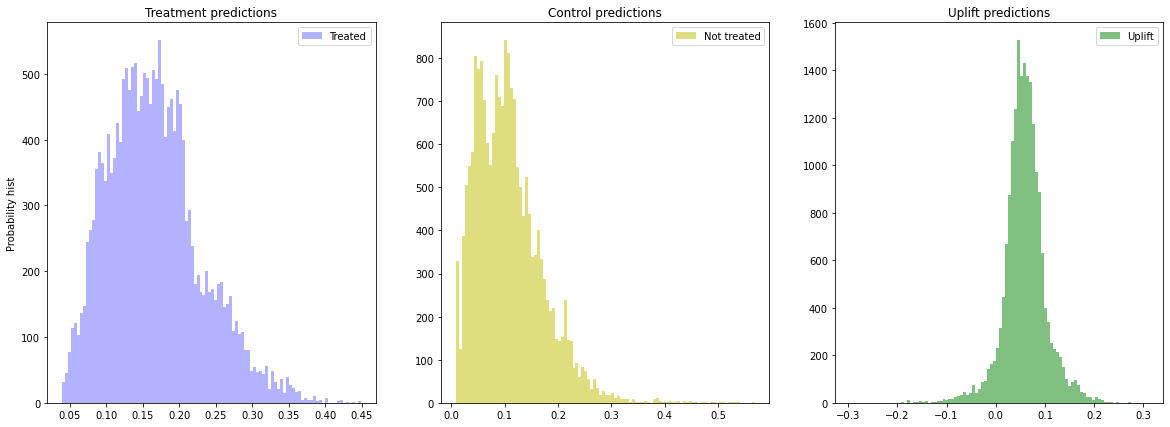

In [70]:
plot_uplift_preds(trmnt_preds=tm.trmnt_preds_, ctrl_preds=tm.ctrl_preds_)

Представим результаты трех моделей в виде сводной таблицы.

In [71]:
pd.DataFrame(data=models_results).sort_values('uplift@30%', ascending=False).set_index('method')

,uplift@10%,uplift@30%
method,,
ClassTransformation,0.272591,0.183828
SoloModel,0.086985,0.097824
TwoModels,0.083775,0.082443
